# Lesson 3 Module 1: Bias–Variance Tradeoff

This notebook demonstrates the bias–variance tradeoff using practical examples.
It builds on Lesson 2 (MLE/MoM estimators) and provides foundation for confidence intervals.

## Learning Objectives
- Define bias, variance, and mean squared error of estimators
- Explain the bias–variance decomposition: MSE = Bias² + Var
- Apply tradeoff concepts to shrinkage estimators and sample variance
- Connect to Lesson 2 estimator properties and Lesson 1 sampling distributions

## Repository Context
- Uses datasets from `shared/data/` where appropriate
- Connects to Lesson 1 (LLN/CLT) and Lesson 2 (MLE/MoM)
- Uses helper functions from the appendix

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style and random seed
sns.set_theme(context="talk", style="whitegrid")
sns.set_palette(["#000000", "#E69F00", "#56B4E9", "#009E73",
                 "#F0E442", "#0072B2", "#D55E00", "#CC79A7"])
rng = np.random.default_rng(2025)

print("Environment setup complete. Random seed: 2025")

Environment setup complete. Random seed: 2025


## 1. Bias, Variance, and MSE Definitions

Let's implement the core concepts and verify the decomposition.

In [10]:
def compute_estimator_properties(estimator_fn, true_theta, gen_fn, n, R=10000):
    """
    Compute empirical bias, variance, and MSE for an estimator.

    Parameters:
    -----------
    estimator_fn : callable
        Function that takes sample and returns estimate
    true_theta : float
        True parameter value
    gen_fn : callable
        Function that generates sample of size n
    n : int
        Sample size
    R : int
        Number of replications

    Returns:
    --------
    dict with bias, variance, mse, and estimates
    """
    estimates = np.empty(R)

    for r in range(R):
        sample = gen_fn(n)
        estimates[r] = estimator_fn(sample)

    bias = np.mean(estimates) - true_theta
    variance = np.var(estimates, ddof=0)
    mse = np.mean((estimates - true_theta)**2)

    return {
        'bias': bias,
        'variance': variance,
        'mse': mse,
        'estimates': estimates,
        'bias_squared': bias**2
    }

print("Function defined: compute_estimator_properties")

Function defined: compute_estimator_properties


In [11]:
# Test the decomposition: MSE should equal Bias² + Variance
true_mu = 5.0
true_sigma = 2.0
n = 10
R = 5000

def sample_mean(x):
    return np.mean(x)

def generate_normal(n):
    return rng.normal(true_mu, true_sigma, n)

props = compute_estimator_properties(sample_mean, true_mu, generate_normal, n, R)

print(f"Sample size: {n}")
print(f"Bias: {props['bias']:.6f}")
print(f"Variance: {props['variance']:.6f}")
print(f"Bias²: {props['bias_squared']:.6f}")
print(f"MSE: {props['mse']:.6f}")
print(f"Bias² + Var: {props['bias_squared'] + props['variance']:.6f}")
print(f"Decomposition check: {abs(props['mse'] - (props['bias_squared'] + props['variance'])) < 1e-10}")

Sample size: 10
Bias: -0.000034
Variance: 0.396466
Bias²: 0.000000
MSE: 0.396466
Bias² + Var: 0.396466
Decomposition check: True


## 2. Shrinkage Estimator Example

Using heights data from the repository to demonstrate shrinkage.

In [12]:
# Load heights data
heights_df = pd.read_csv("../../../shared/data/heights_weights_sample.csv")
heights = heights_df['height_cm'].values

print(f"Loaded {len(heights)} height measurements")
print(f"Sample mean: {np.mean(heights):.2f} cm")
print(f"Sample std: {np.std(heights, ddof=1):.2f} cm")

# Use population mean as prior (approximate)
mu_0 = 170  # Prior guess for average height
true_mu = np.mean(heights)  # Use sample mean as proxy for true mean

Loaded 10 height measurements
Sample mean: 170.20 cm
Sample std: 9.08 cm


In [13]:
def shrinkage_estimator(x, alpha, mu_0):
    """Shrinkage estimator: alpha * mean(x) + (1-alpha) * mu_0"""
    return alpha * np.mean(x) + (1 - alpha) * mu_0

# Compare shrinkage estimators for different alpha values
n_small = 20  # Small sample
alpha_values = np.linspace(0, 1, 21)
R = 2000

results = []
for alpha in alpha_values:
    def est_fn(x):
        return shrinkage_estimator(x, alpha, mu_0)

    props = compute_estimator_properties(est_fn, true_mu, generate_normal, n_small, R)
    results.append({
        'alpha': alpha,
        'bias': props['bias'],
        'variance': props['variance'],
        'mse': props['mse'],
        'bias_squared': props['bias_squared']
    })

shrinkage_df = pd.DataFrame(results)
print("Computed shrinkage estimator properties for alpha in [0,1]")

Computed shrinkage estimator properties for alpha in [0,1]


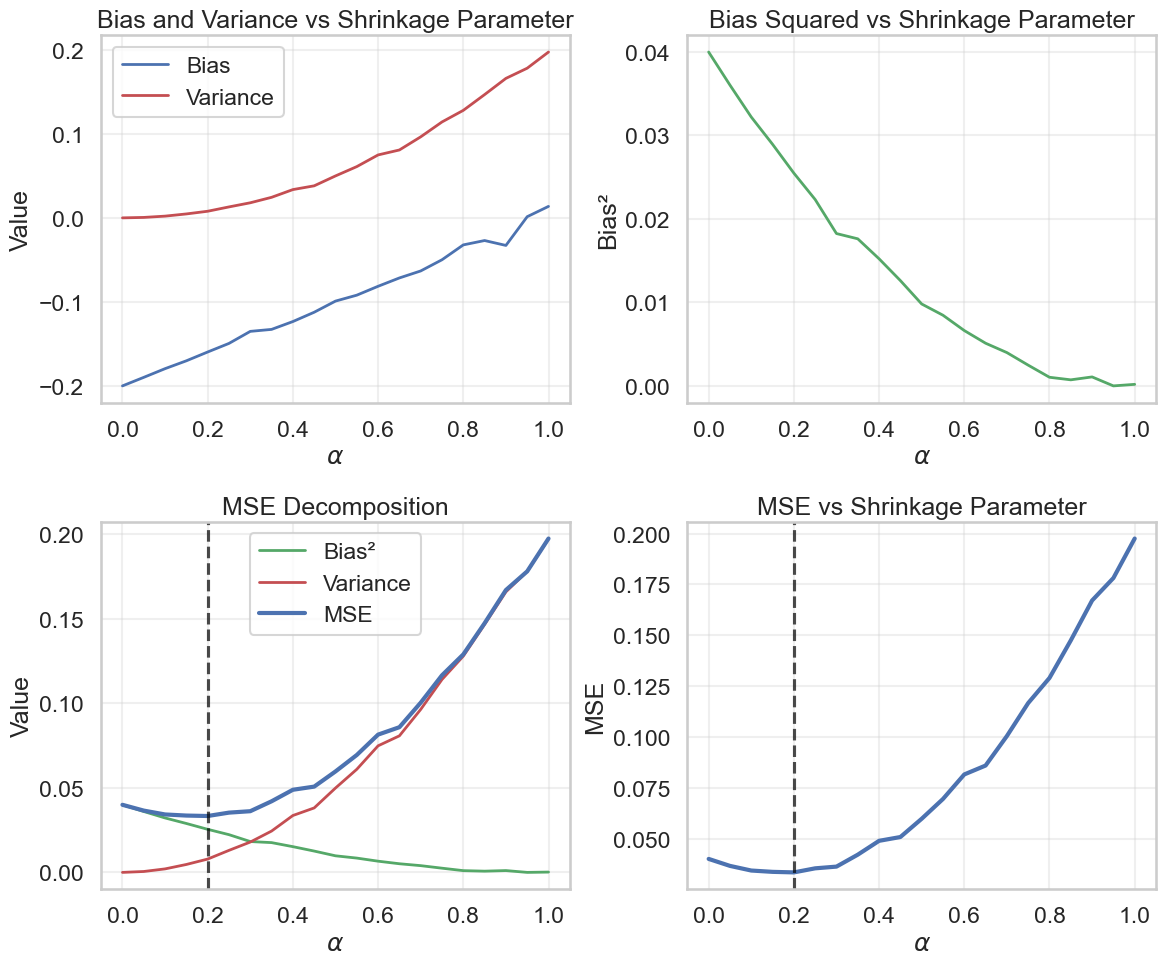

Optimal shrinkage parameter: 0.200
Minimum MSE: 0.033371


In [22]:
# Plot the tradeoff
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Bias and variance vs alpha
axes[0,0].plot(shrinkage_df['alpha'], shrinkage_df['bias'], 'b-', linewidth=2, label='Bias')
axes[0,0].plot(shrinkage_df['alpha'], shrinkage_df['variance'], 'r-', linewidth=2, label='Variance')
axes[0,0].set_xlabel(r'$\alpha$')
axes[0,0].set_ylabel('Value')
axes[0,0].set_title('Bias and Variance vs Shrinkage Parameter')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Bias squared vs alpha
axes[0,1].plot(shrinkage_df['alpha'], shrinkage_df['bias_squared'], 'g-', linewidth=2)
axes[0,1].set_xlabel(r'$\alpha$')
axes[0,1].set_ylabel('Bias²')
axes[0,1].set_title('Bias Squared vs Shrinkage Parameter')
axes[0,1].grid(True, alpha=0.3)

# MSE decomposition
axes[1,0].plot(shrinkage_df['alpha'], shrinkage_df['bias_squared'], 'g-', linewidth=2, label='Bias²')
axes[1,0].plot(shrinkage_df['alpha'], shrinkage_df['variance'], 'r-', linewidth=2, label='Variance')
axes[1,0].plot(shrinkage_df['alpha'], shrinkage_df['mse'], 'b-', linewidth=3, label='MSE')
axes[1,0].set_xlabel(r'$\alpha$')
axes[1,0].set_ylabel('Value')
axes[1,0].set_title('MSE Decomposition')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Find optimal alpha
optimal_idx = shrinkage_df['mse'].argmin()
optimal_alpha = shrinkage_df.iloc[optimal_idx]['alpha']
axes[1,0].axvline(optimal_alpha, color='black', linestyle='--', alpha=0.7)
# axes[1,0].text(optimal_alpha + 0.05, 0.5, f'Optimal α = {optimal_alpha:.2f}',
#                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# MSE vs alpha
axes[1,1].plot(shrinkage_df['alpha'], shrinkage_df['mse'], 'b-', linewidth=3)
axes[1,1].axvline(optimal_alpha, color='black', linestyle='--', alpha=0.7)
axes[1,1].set_xlabel(r'$\alpha$')
axes[1,1].set_ylabel('MSE')
axes[1,1].set_title('MSE vs Shrinkage Parameter')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/bias_variance_tradeoff.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Optimal shrinkage parameter: {optimal_alpha:.3f}")
print(f"Minimum MSE: {shrinkage_df['mse'].min():.6f}")

## 3. Sample Variance Estimators Comparison

Compare the unbiased and MLE variance estimators.

In [15]:
def unbiased_variance(x):
    """Unbiased sample variance (denominator n-1)"""
    return np.var(x, ddof=1)

def mle_variance(x):
    """MLE sample variance (denominator n)"""
    return np.var(x, ddof=0)

# Compare across different sample sizes
sample_sizes = [5, 10, 20, 50, 100]
R = 5000
true_sigma2 = 4.0  # True variance

comparison_results = []
for n in sample_sizes:
    # Unbiased estimator
    props_unbiased = compute_estimator_properties(
        unbiased_variance, true_sigma2, generate_normal, n, R
    )

    # MLE estimator
    props_mle = compute_estimator_properties(
        mle_variance, true_sigma2, generate_normal, n, R
    )

    comparison_results.append({
        'n': n,
        'unbiased_bias': props_unbiased['bias'],
        'unbiased_var': props_unbiased['variance'],
        'unbiased_mse': props_unbiased['mse'],
        'mle_bias': props_mle['bias'],
        'mle_var': props_mle['variance'],
        'mle_mse': props_mle['mse']
    })

var_comparison_df = pd.DataFrame(comparison_results)
print("Computed variance estimator comparison across sample sizes")

Computed variance estimator comparison across sample sizes


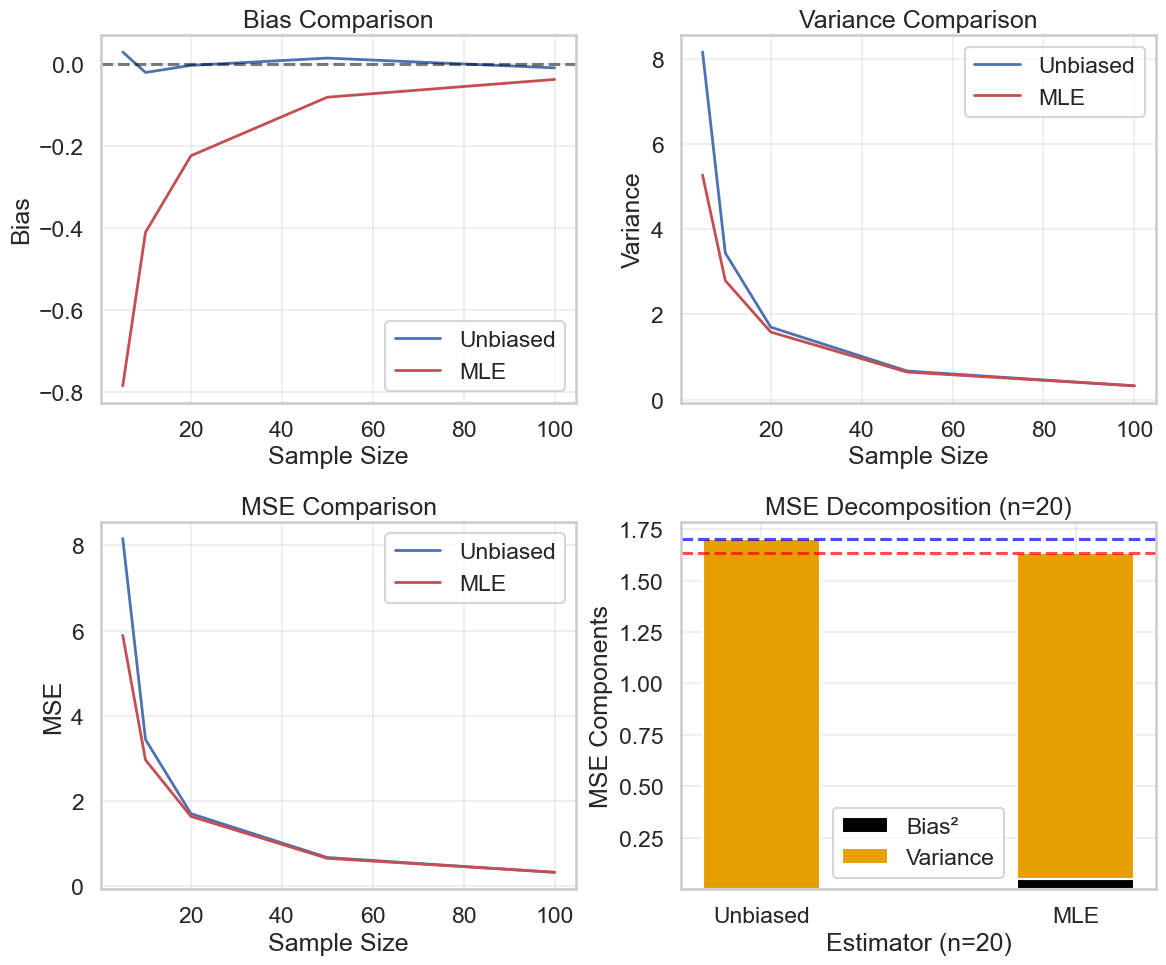

Variance estimator comparison complete
For n=20: Unbiased MSE = 1.700968, MLE MSE = 1.636267


In [16]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Bias comparison
axes[0,0].plot(var_comparison_df['n'], var_comparison_df['unbiased_bias'], 'b-', linewidth=2, label='Unbiased')
axes[0,0].plot(var_comparison_df['n'], var_comparison_df['mle_bias'], 'r-', linewidth=2, label='MLE')
axes[0,0].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[0,0].set_xlabel('Sample Size')
axes[0,0].set_ylabel('Bias')
axes[0,0].set_title('Bias Comparison')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Variance comparison
axes[0,1].plot(var_comparison_df['n'], var_comparison_df['unbiased_var'], 'b-', linewidth=2, label='Unbiased')
axes[0,1].plot(var_comparison_df['n'], var_comparison_df['mle_var'], 'r-', linewidth=2, label='MLE')
axes[0,1].set_xlabel('Sample Size')
axes[0,1].set_ylabel('Variance')
axes[0,1].set_title('Variance Comparison')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# MSE comparison
axes[1,0].plot(var_comparison_df['n'], var_comparison_df['unbiased_mse'], 'b-', linewidth=2, label='Unbiased')
axes[1,0].plot(var_comparison_df['n'], var_comparison_df['mle_mse'], 'r-', linewidth=2, label='MLE')
axes[1,0].set_xlabel('Sample Size')
axes[1,0].set_ylabel('MSE')
axes[1,0].set_title('MSE Comparison')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# MSE decomposition for n=20
n_idx = 2  # n=20
unbiased_mse = var_comparison_df.iloc[n_idx]['unbiased_mse']
unbiased_bias2 = var_comparison_df.iloc[n_idx]['unbiased_bias']**2
unbiased_var = var_comparison_df.iloc[n_idx]['unbiased_var']

mle_mse = var_comparison_df.iloc[n_idx]['mle_mse']
mle_bias2 = var_comparison_df.iloc[n_idx]['mle_bias']**2
mle_var = var_comparison_df.iloc[n_idx]['mle_var']

x_pos = var_comparison_df.iloc[n_idx]['n']
axes[1,1].bar([x_pos-2, x_pos+2], [unbiased_bias2, mle_bias2], width=1.5, label='Bias²')
axes[1,1].bar([x_pos-2, x_pos+2], [unbiased_var, mle_var], width=1.5, bottom=[unbiased_bias2, mle_bias2], label='Variance')
axes[1,1].axhline(unbiased_mse, color='blue', linestyle='--', alpha=0.7)
axes[1,1].axhline(mle_mse, color='red', linestyle='--', alpha=0.7)
axes[1,1].set_xlabel('Estimator (n=20)')
axes[1,1].set_ylabel('MSE Components')
axes[1,1].set_title('MSE Decomposition (n=20)')
axes[1,1].set_xticks([x_pos-2, x_pos+2])
axes[1,1].set_xticklabels(['Unbiased', 'MLE'])
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/variance_estimators_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Variance estimator comparison complete")
print(f"For n=20: Unbiased MSE = {unbiased_mse:.6f}, MLE MSE = {mle_mse:.6f}")

## 4. Summary and Key Takeaways

This notebook demonstrated:
1. The fundamental bias-variance decomposition
2. How shrinkage estimators trade bias for reduced variance
3. The practical differences between unbiased and MLE variance estimators
4. How to evaluate estimators using MSE in practice

Key insights:
- Unbiased estimators aren't always better when variance is high
- The optimal estimator depends on the specific use case
- Simulation is essential for understanding finite-sample properties